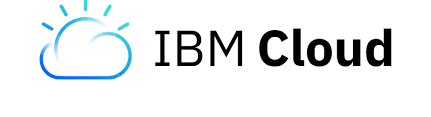

# CASE STUDY - topic modeling and feature engineering


[Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of using domain knowledge of your data to create features that can be leveraged by machine learning.  That is not a hard definition, because sometimes it is used in a context where features are transformed for machine learning, but the inclusion of domain knowledge is not implied.  

It is unfortunately common that for large datasets engineered features are not easy to create.  When there are many features generally only a small number play an important roll when it comes to prediction.  Furthermore,  domain insight is even more difficult to fold into the model when there are hundreds or thousands of features to keep in mind.  However, there is a middle ground---much of the worlds knowledge is locked up in language.  In this case study we will use topic modeling to gather insight from text.  Ideally, the result of these types of experiments would be shared with domain experts to further engineer features that are relevant when it comes to your business opportunity.

In [13]:
!pip install pyLDAvis


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=67340) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [6]:
!pip install nltk


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=67340) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [9]:
import nltk
from nltk import WordNetLemmatizer
from nltk import PunktTokenizer

In [ ]:
import os
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from string import punctuation, printable
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

try:
    import pyLDAvis
    import pyLDAvis.lda_model
except:
    raise Exception("'pip install pyldavis' before running this notebook")

pyLDAvis.enable_notebook()    
sns.set_theme()


DATA_DIR = os.path.join("..","data")

## Synopsis

   >Goal:  AAVAIL has recently enabled comments on the core streaming service.  The data science team knows that   this will be an incredibly important source of data going forward.  It will be used inform customer retention, product quality, product market fit and more.  Comments are going live next week and being the diligent data scientist that you are your plan is to build a topic modeling pipeline that will consume the comments and create visualizations that can be used to communicate with domain experts.
  
## Outline

1. EDA - summary tables, use tSNE to visualize the data
2. Create a transfomation pipelines for NMF and LDA
3. Use ldaviz and wordclouds to get insight into the clusters

## Data

Even before receiving the first comment, we want to start building our Pipeline using a proxy dataset. In this study Case we will work with a dataset publicly available dataset of movie reviews.

* [Here](http://www.nltk.org/nltk_data) is the web page that references all the public dataset that NLTK provide. In this Study Case we will work with the 'Sentiment Polarity Dataset Version 2.0' dataset. (The dataset has already been downloaded and is in the data folder of the working directory)
* For more examples of applications with these data see [NLTK's book chapter that uses these data](https://www.nltk.org/book/ch06.html)

In [32]:
from sklearn.datasets import load_files
import os

movie_reviews = load_files(
    os.path.join(DATA_DIR, "movie_reviews"),
    encoding="utf-8",
    shuffle=True
)

X = movie_reviews.data
y = movie_reviews.target
target_names = movie_reviews.target_names
print (target_names)
print(X[1])

['neg', 'pos']
good films are hard to find these days . 
great films are beyond rare . 
proof of life , russell crowe's one-two punch of a deft kidnap and rescue thriller , is one of those rare gems . 
a taut drama laced with strong and subtle acting , an intelligent script , and masterful directing , together it delivers something virtually unheard of in the film industry these days , genuine motivation in a story that rings true . 
consider the strange coincidence of russell crowe's character in proof of life making the moves on a distraught wife played by meg ryan's character in the film -- all while the real russell crowe was hitching up with married woman meg ryan in the outside world . 
i haven't seen this much chemistry between actors since mcqueen and mcgraw teamed up in peckinpah's masterpiece , the getaway . 
but enough with the gossip , let's get to the review . 
the film revolves around the kidnapping of peter bowman ( david morse ) , an american engineer working in south a

### QUESTION 1

The main focus of this exercise is to enable visualization of topics, but these topics can be used as additional 
features for prediction tasks.  The goal of this case study is to ensure that you are comfortable with natural language processing pipelines and topic modeling tools. 

There are many ways to process tokens (words, dates, emojis etc).  NLTK is often used to pre-process text data before the tokens are vectorized.  Generally, the tokens are modified via [stemming or lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).  The next code block provides a lemmatization function that makes use of the library [spacy](https://spacy.io/).  You will need to install it and download the English language reference material as follows.  Stopwords are words that are very common or otherwise irrelevant we use a default list here, but it is an important part of NLP pipelines that needs to be customized for the subject area. Use the following function to process the corpus (this can take a few minutes)

```bash
~$ pip install spacy
~$ python -m spacy download en
```

If you prefer to use NLTK then you could use a simple lemmatizer like the WordLemmatizer.

In [38]:
!pip install spacy

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=67340) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [40]:
!python -m spacy download en_core_web_sm

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/pty.py:95: DeprecationWarning: This process (pid=67340) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.4 MB/s  0:00:05 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [41]:
import spacy
STOPLIST = ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo", "film", "movie", "make"])

if not 'nlp' in locals():
    print("Loading English Module...")
    nlp = spacy.load('en_core_web_sm')

def lemmatize_document(doc, stop_words=None):
    """
    takes a list of strings where each string is a document
    returns a processed list of strings
    """
    
    if not stop_words:
        stop_words = set([])
  
    ## ensure working with string
    doc = str(doc)
    doc = doc.replace('\\n','')
    doc = doc.replace('\\t','')

    # First remove punctuation form string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)

    # remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
            
    # Run the doc through spaCy
    doc = nlp(clean_doc)

    # Lemmatize and lower text
    tokens = [re.sub(r"\W+","",token.lemma_.lower()) for token in doc ]
    tokens = [t for t in tokens if len(t) > 1]
    
    return ' '.join(w for w in tokens if w not in stop_words)    

## example usage
corpus = ['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']
processed = [lemmatize_document(doc, STOPLIST) for doc in corpus]
print(processed[0])
processed = [lemmatize_document(doc, None) for doc in corpus]
print("\n"+processed[0])

Loading English Module...
fool people time people time fool people time abraham lincoln

you can fool some of the people all of the time and all of the people some of the time but you can not fool all of the people all of the time abraham lincoln


In [44]:
## YOUR CODE HERE

## Preprocess all the reviews of the corpus with the lemmatize_document() 
## function to create a list of cleaned reviews.
# processed = [lemmatize_document(review, STOPLIST)for review in X]
processed = [lemmatize_document(review, STOPLIST)for review in X]
print("processing done.")

processing done.


In [48]:
print(processed.__len__())
print(y.__len__())

2000
2000


### QUESTION 2

Use the CountVectorizer from sklearn to vectorize the documents.

Additional resources:

* [scikit-learn CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [scikit-learn working with text](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

Because this is an exercise in visualization set the `max_features` to something like 500.  In the context of supervised learning it is reasonable to grid-search to optimize this parameter.

In [51]:
## YOUR CODE HERE

max_features = 500

# Create a CountVectorizer object
tf_vectorizer = CountVectorizer(max_features=max_features)

# Fit and transform this object to the processed reviews
tf = tf_vectorizer.fit_transform(processed, y=None)
print("ready")

ready


In [62]:
print(tf[1999])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 86 stored elements and shape (1, 500)>
  Coords	Values
  (0, 26)	3
  (0, 248)	1
  (0, 443)	3
  (0, 486)	1
  (0, 187)	1
  (0, 261)	1
  (0, 255)	1
  (0, 412)	3
  (0, 226)	2
  (0, 431)	1
  (0, 60)	3
  (0, 126)	1
  (0, 167)	1
  (0, 125)	1
  (0, 254)	1
  (0, 379)	2
  (0, 24)	1
  (0, 215)	2
  (0, 441)	1
  (0, 419)	1
  (0, 178)	5
  (0, 481)	3
  (0, 321)	2
  (0, 4)	1
  (0, 88)	6
  :	:
  (0, 43)	1
  (0, 52)	2
  (0, 159)	1
  (0, 464)	1
  (0, 229)	1
  (0, 262)	1
  (0, 349)	1
  (0, 19)	1
  (0, 326)	1
  (0, 498)	1
  (0, 269)	1
  (0, 334)	1
  (0, 231)	1
  (0, 272)	2
  (0, 259)	1
  (0, 455)	1
  (0, 324)	1
  (0, 294)	1
  (0, 353)	2
  (0, 311)	6
  (0, 286)	1
  (0, 17)	1
  (0, 458)	2
  (0, 460)	1
  (0, 108)	1


### QUESTION 3

Fit a LDA model to the corpus. For example, you could use something like the following.

```python
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

lda_model.fit(tf)
```


* [scikit-learn's LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
* [scikit-learn's user guide for LDA](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)

In [118]:
## YOUR CODE HERE
n_topics = 10

# Create an LDA object
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='batch',random_state=42)

# Fit the model to the bag of word we created earlier
lda_model.fit(tf)

,"n_components n_components: int, default=10Number of topics... versionchanged:: 0.19 ``n_topics`` was renamed to ``n_components``",10
,"doc_topic_prior doc_topic_prior: float, default=NonePrior of document topic distribution `theta`. If the value is None,defaults to `1 / n_components`.In [1]_, this is called `alpha`.",None
,"topic_word_prior topic_word_prior: float, default=NonePrior of topic word distribution `beta`. If the value is None, defaultsto `1 / n_components`.In [1]_, this is called `eta`.",None
,"learning_method learning_method: {'batch', 'online'}, default='batch'Method used to update `_component`. Only used in :meth:`fit` method.In general, if the data size is large, the online update will be muchfaster than the batch update.Valid options:- 'batch': Batch variational Bayes method. Use all training data in each EM update. Old `components_` will be overwritten in each iteration.- 'online': Online variational Bayes method. In each EM update, use mini-batch of training data to update the ``components_`` variable incrementally. The learning rate is controlled by the ``learning_decay`` and the ``learning_offset`` parameters... versionchanged:: 0.20 The default learning method is now ``""batch""``.",'batch'
,"learning_decay learning_decay: float, default=0.7It is a parameter that control learning rate in the online learningmethod. The value should be set between (0.5, 1.0] to guaranteeasymptotic convergence. When the value is 0.0 and batch_size is``n_samples``, the update method is same as batch learning. In theliterature, this is called kappa.",0.7
,"learning_offset learning_offset: float, default=10.0A (positive) parameter that downweights early iterations in onlinelearning. It should be greater than 1.0. In the literature, this iscalled tau_0.",10.0
,"max_iter max_iter: int, default=10The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the :meth:`fit` method, and not the:meth:`partial_fit` method.",10
,"batch_size batch_size: int, default=128Number of documents to use in each EM iteration. Only used in onlinelearning.",128
,"evaluate_every evaluate_every: int, default=-1How often to evaluate perplexity. Only used in `fit` method.set it to 0 or negative number to not evaluate perplexity intraining at all. Evaluating perplexity can help you check convergencein training process, but it will also increase total training time.Evaluating perplexity in every iteration might increase training timeup to two-fold.",-1
,"total_samples total_samples: int, default=1e6Total number of documents. Only used in the :meth:`partial_fit` method.",1000000.0
,"perp_tol perp_tol: float, default=1e-1Perplexity tolerance. Only used when ``evaluate_every`` is greater than 0.",0.1


## QUESTION 4

Visualize the corpus using [pyldavis](https://github.com/bmabey/pyLDAvis).

```python
pyLDAvis.sklearn.prepare(lda_model,tf, tf_vectorizer, R=20)
```

* [PyLDAViz documentation](https://pyldavis.readthedocs.io/en/latest)
* [PyLDAViz demos](https://pyldavis.readthedocs.io/en/latest/readme.html#video-demos)

In [119]:
topic_term_dists = lda_model.components_
topic_term_dists = topic_term_dists / topic_term_dists.sum(axis=1, keepdims=True)
print(topic_term_dists.shape)

doc_topic_dists = lda_model.transform(tf)
print(doc_topic_dists.shape)
doc_lengths = np.array(tf.sum(axis=1)).flatten()
print(doc_lengths.shape)
vocab = tf_vectorizer.get_feature_names_out()
print(vocab.__len__())

(10, 500)
(2000, 10)
(2000,)
500


In [120]:
print(tf.shape)
term_frequency = np.asarray(tf.sum(axis=0)).ravel()
print(term_frequency.shape)

(2000, 500)
(500,)


In [121]:
## YOUR CODE HERE

movies_vis_data = pyLDAvis.prepare(
    topic_term_dists,
    doc_topic_dists,
    doc_lengths,
    vocab,
    term_frequency
)
movies_vis_data
# 'doc_topic_dists', 'doc_lengths', 'vocab', and 'term_frequency'

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.010945  0.034289       1        1  20.499603
7      0.103127 -0.015285       2        1  16.786825
9      0.047169 -0.011346       3        1  12.335311
3     -0.033177  0.048021       4        1  10.760979
0      0.056189  0.053877       5        1   9.291376
8     -0.068081 -0.045291       6        1   7.069956
5      0.024684 -0.063256       7        1   6.656231
1      0.029570 -0.002536       8        1   6.436024
6     -0.090956  0.089116       9        1   5.379112
4     -0.079470 -0.087589      10        1   4.784584, topic_info=         Term        Freq        Total Category  logprob  loglift
11      alien  567.000000   567.000000  Default  30.0000  30.0000
69     comedy  880.000000   880.000000  Default  29.0000  29.0000
301  original  713.000000   713.000000  Default  28.0000  28.0000
475       war  527.000000   527.000000  Default  27.0000  27.0000
170     funny  858.000000   858.000000  Default  26.0000  26.0000
..        ...         ...          ...      ...      ...      ...
412      star   95.208330  1280.605347  Topic10  -4.8217   0.4408
372     scene   99.597260  2638.605756  Topic10  -4.7766  -0.2371
226      just   81.842753  2909.707279  Topic10  -4.9729  -0.5312
248      like   78.726316  3824.784818  Topic10  -5.0118  -0.8435
377    screen   72.758585   663.937878  Topic10  -5.0906   0.8287

[542 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.401358   able
0         2  0.115095   able
0         3  0.100339   able
0         4  0.053121   able
0         5  0.067877   able
...     ...       ...    ...
499       6  0.090705  young
499       7  0.003534  young
499       8  0.060077  young
499       9  0.166096  young
499      10  0.063611  young

[2721 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 10, 4, 1, 9, 6, 2, 7, 5])

## QUESTION 5

Try different numbers of clusters until there is decent separation in the visualization

In [164]:
## YOUR CODE HERE

# set the number of topics
n_topics = 10

# Create the LDA model
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='batch',random_state=42)

# fit and transform the LDA model to the vecotrized corpus
lda_transformed = lda_model.fit_transform(tf)

# use the pyLDAvis to visualise the topics
topic_term_dists = lda_model.components_
topic_term_dists = topic_term_dists / topic_term_dists.sum(axis=1, keepdims=True)
print(topic_term_dists.shape)

doc_topic_dists = lda_transformed
print(doc_topic_dists.shape)
doc_lengths = np.array(tf.sum(axis=1)).flatten()
print(doc_lengths.shape)
vocab = tf_vectorizer.get_feature_names_out()
print(vocab)

print(tf.shape)
term_frequency = np.asarray(tf.sum(axis=0)).ravel()
print(term_frequency.shape)

movies_vis_data = pyLDAvis.prepare(
    topic_term_dists,
    doc_topic_dists,
    doc_lengths,
    vocab,
    term_frequency
)
movies_vis_data

(10, 500)
(2000, 10)
(2000,)
['able' 'act' 'acting' 'action' 'actor' 'actress' 'actually' 'add' 'age'
 'agent' 'ago' 'alien' 'allow' 'america' 'american' 'apparently' 'appear'
 'approach' 'art' 'ask' 'aspect' 'attack' 'attempt' 'attention' 'audience'
 'away' 'bad' 'base' 'basically' 'batman' 'battle' 'beautiful' 'begin'
 'beginning' 'believe' 'ben' 'big' 'bit' 'black' 'body' 'book' 'boring'
 'boy' 'break' 'bring' 'brother' 'build' 'camera' 'car' 'care' 'career'
 'carry' 'case' 'cast' 'catch' 'cause' 'certain' 'certainly' 'chance'
 'change' 'character' 'chase' 'child' 'choose' 'chris' 'city' 'classic'
 'close' 'come' 'comedy' 'comic' 'complete' 'completely' 'computer'
 'consider' 'contain' 'cool' 'cop' 'couple' 'course' 'cover' 'create'
 'credit' 'crew' 'crime' 'cut' 'dark' 'daughter' 'david' 'day' 'dead'
 'deal' 'death' 'decide' 'deep' 'deliver' 'deserve' 'despite' 'develop'
 'dialogue' 'die' 'different' 'difficult' 'direct' 'direction' 'director'
 'discover' 'disney' 'dog' 'doubt' 'dr

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.010945  0.034289       1        1  20.499603
7      0.103127 -0.015285       2        1  16.786825
9      0.047169 -0.011346       3        1  12.335311
3     -0.033177  0.048021       4        1  10.760979
0      0.056189  0.053877       5        1   9.291376
8     -0.068081 -0.045291       6        1   7.069956
5      0.024684 -0.063256       7        1   6.656231
1      0.029570 -0.002536       8        1   6.436024
6     -0.090956  0.089116       9        1   5.379112
4     -0.079470 -0.087589      10        1   4.784584, topic_info=         Term        Freq        Total Category  logprob  loglift
11      alien  567.000000   567.000000  Default  30.0000  30.0000
69     comedy  880.000000   880.000000  Default  29.0000  29.0000
301  original  713.000000   713.000000  Default  28.0000  28.0000
475       war  527.000000   527.000000  Default  27.0000  27.0000
170     funny  858.000000   858.000000  Default  26.0000  26.0000
..        ...         ...          ...      ...      ...      ...
412      star   95.208330  1280.605347  Topic10  -4.8217   0.4408
372     scene   99.597260  2638.605756  Topic10  -4.7766  -0.2371
226      just   81.842753  2909.707279  Topic10  -4.9729  -0.5312
248      like   78.726316  3824.784818  Topic10  -5.0118  -0.8435
377    screen   72.758585   663.937878  Topic10  -5.0906   0.8287

[542 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.401358   able
0         2  0.115095   able
0         3  0.100339   able
0         4  0.053121   able
0         5  0.067877   able
...     ...       ...    ...
499       6  0.090705  young
499       7  0.003534  young
499       8  0.060077  young
499       9  0.166096  young
499      10  0.063611  young

[2721 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 10, 4, 1, 9, 6, 2, 7, 5])

The visualization here can help determine a reasonable number of number of clusters and it can serve as a communication tool.  If the goal was to find topics that are associated with customer profiles then you would likely work with folks in marketing to refine the clustering.  There are a couple of parameters than can be used to modify the clustering and visualization.  The discovery of meaningful topics is a form of feature engineering.

## QUESTION 6

If you were to use the topics from this model to inform clustering or supervised learning you would first need to be able to extract and represent them as a matrix.  Along the same lines if you were to populate a report with tabular descriptions of the data then you will need to be able to extract topic representations.  Here is a starter function

In [130]:
def get_top_words(model, feature_names, n_top_words):
    """
    Get the top words defining the different topics of the LDA model
    INPUT : the LDA model, the names of the features of the bag of word (these are the actual words in the vocabulary) 
    and the number of top words.
    RETURN : A dictionary where the keys are the topic's ID and the values are the lists of the n_top_words top words.
    
    """
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        _top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words[str(topic_idx)] = _top_words
    return top_words

Use the function to print the top k words for each topic

In [144]:
## YOUR CODE HERE

## set n_top_words
top_words = 15

## get the vectorizer's feature names
tf_feature_names = tf_vectorizer.get_feature_names_out()

## get the top words for each topic
top_words = get_top_words(lda_model, tf_feature_names, top_words)

## print the topics and the top words of each topic
print(top_words)
for i, words in top_words.items():
    print(f"topic {i} = {words}")

{'0': ['comedy', 'funny', 'good', 'like', 'just', 'laugh', 'play', 'character', 'time', 'joke', 'big', 'really', 'come', 'humor', 'little'], '1': ['character', 'horror', 'like', 'time', 'girl', 'scream', 'know', 'thing', 'killer', 'scene', 'director', 'just', 'good', 'watch', 'murder'], '2': ['character', 'life', 'story', 'like', 'good', 'love', 'man', 'scene', 'time', 'just', 'people', 'way', 'play', 'come', 'work'], '3': ['character', 'scene', 'play', 'performance', 'time', 'action', 'good', 'man', 'actor', 'like', 'role', 'book', 'life', 'plot', 'director'], '4': ['alien', 'effect', 'war', 'star', 'character', 'special', 'time', 'human', 'story', 'world', 'planet', 'year', 'good', 'original', 'earth'], '5': ['like', 'bad', 'just', 'good', 'really', 'scene', 'time', 'look', 'know', 'action', 'think', 'say', 'thing', 'guy', 'plot'], '6': ['new', 'story', 'joe', 'disney', 'voice', 'like', 'young', 'city', 'little', 'child', 'come', 'music', 'feature', 'family', 'king']}
topic 0 = ['com

NameError: name 'topic_idx' is not defined

## QUESTION (EXTRA CREDIT) 7

If you used `transform` on your original tokens you should have a `2000 x k` array where `k` is the number of topics you choose.  Create a PCA or tSNE visualization that projects this matrix into lower dimensional space then uses colors to indicate which documents belong to a topic (e.g. probability > 0.5).

In [165]:
## YOUR CODE HERE

doc_topic_dists = lda_model.transform(tf)
topic_lables = np.where(doc_topic_dists.max(axis=1) > 0.5, np.argmax(doc_topic_dists, axis = 1), -1)

pca = PCA(n_components=2, random_state=42)
doc_topic_PCA = pca.fit_transform(doc_topic_dists)


tsne = TSNE(n_components=2, perplexity=30, random_state=42, init = 'pca')
doc_topic_tsne = tsne.fit_transform(doc_topic_dists)



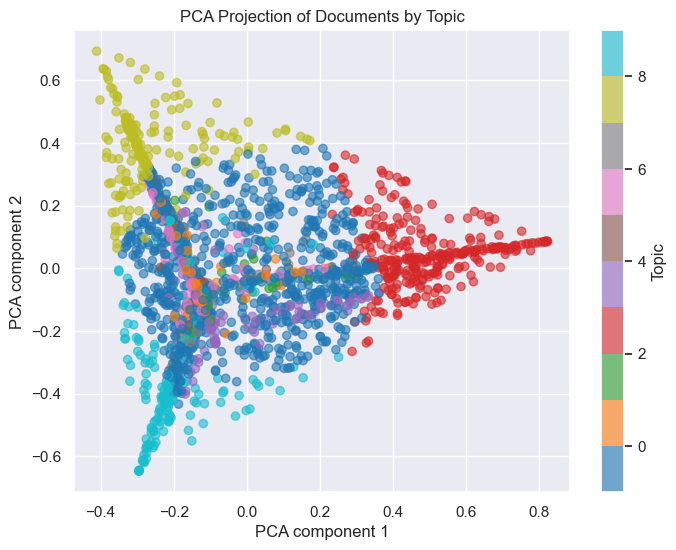

In [166]:
plt.figure(figsize = (8,6))
scatter = plt.scatter(
    doc_topic_PCA[:, 0],
    doc_topic_PCA[:, 1],
    c = topic_lables,
    cmap = "tab10",
    alpha=0.6   
)

plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.title("PCA Projection of Documents by Topic")
plt.colorbar(scatter, label="Topic")
plt.show()

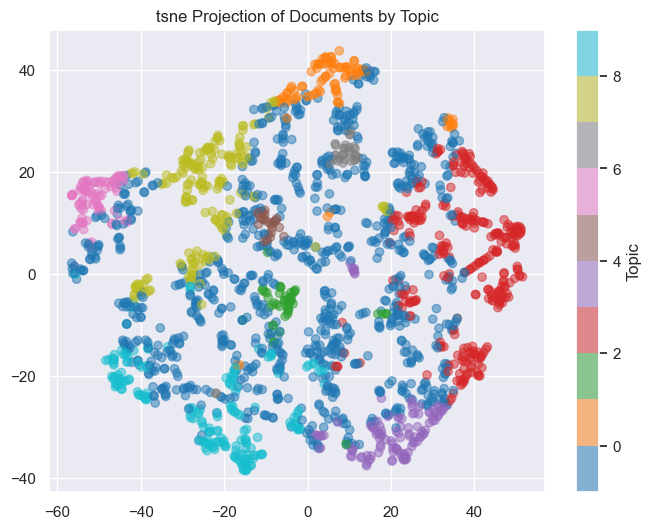

In [167]:
plt.figure(figsize = (8,6))
scatter = plt.scatter(
    doc_topic_tsne[:, 0],
    doc_topic_tsne[:, 1],
    c = topic_lables,
    cmap = "tab10",
    alpha=0.5
)

plt.title("tsne Projection of Documents by Topic")
plt.colorbar(scatter, label="Topic")
plt.show()